In [17]:
import time, os, random
from types import SimpleNamespace

import math
import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import gym
from importnb import Notebook
with Notebook():
    from jetbot_sim_environment import JetbotSimEnv
    from action_conditioned_diffusion_world_model_gemini import forward_diffusion_sample
    import config  # contains DEVICE, IMAGE_SIZE, etc.

device = config.DEVICE
print(f"Using device: {device}")


Using device: cuda


In [18]:
MODE = "sim"          # "sim" or "real"
JETBOT_IP = "192.168.1.42"
EPISODES = 5          # used in sim mode
STEPS = 5            # steps per episode (sim) or per run (real)
N_SEQUENCES = 3      # random action sequences sampled each step
HORIZON = 5          # planning horizon (timesteps)
GAMMA = 0.99          # discount factor
STEP_FPS_REAL = 3.0   # actuation / capture rate for the real bot
transform = config.TRANSFORM

In [19]:
def tensor_to_rgb(tensor):
    """Convert a single image tensor (3,H,W) in [-1,1] to uint8 RGB."""
    img = tensor.detach().cpu().clamp(-1,1)
    img = ((img + 1) / 2).numpy()            # 0‑1
    img = np.transpose(img, (1,2,0)) * 255.0 # H,W,3 in 0‑255
    return img.astype(np.uint8)

In [20]:
@torch.no_grad()
def world_model_predict_next(world_model, reward_model,
                             cur_frame, prev_frames, action_tensor,
                             betas, alphas_cumprod, num_timesteps):
    """Predict next frame + reward for a batch in parallel."""
    B = cur_frame.shape[0]
    t_sample = torch.full((B,), num_timesteps - 1, dtype=torch.long, device=device)
    x, _ = forward_diffusion_sample(cur_frame, t_sample, betas, alphas_cumprod, device)

    for i in reversed(range(1, num_timesteps)):
        t = torch.full((B,), i, dtype=torch.long, device=device)
        eps = world_model(x, t, action_tensor, prev_frames)
        alpha = (1. - betas[t]).view(-1, 1, 1, 1)
        alpha_hat = alphas_cumprod[t].view(-1, 1, 1, 1)
        beta  = betas[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
        x = 1/torch.sqrt(alpha) * (x - ((1 - alpha)/torch.sqrt(1 - alpha_hat)) * eps) + torch.sqrt(beta)*noise
    next_frame = x
    reward = reward_model(next_frame).view(-1)
    return next_frame, reward

In [21]:
@torch.no_grad()
def choose_action_mpc(ctx, cur_frame, prev_frames, N, H, gamma):
    """Return the index of the first action of the best sequence.
    ctx must expose: world_model, reward_estimator, betas,
    alphas_cumprod, num_timesteps, num_prev_frames, _action_map,
    action_space.n
    """
    BATCH = N
    cur_batch  = cur_frame.repeat(BATCH,1,1,1)
    prev_batch = prev_frames.repeat(BATCH,1,1,1)
    seqs = torch.randint(0, ctx.action_space.n, (BATCH, H), device=device)
    action_values = torch.tensor([ctx._action_map[i] for i in range(ctx.action_space.n)],
                                 device=device)
    returns = torch.zeros(BATCH, device=device)

    cur_seq  = cur_batch
    prev_seq = prev_batch
    for t in range(H):
        a_idx  = seqs[:, t]
        a_val  = action_values[a_idx].unsqueeze(1)  # (B,1)
        cur_seq, r = world_model_predict_next(ctx.world_model,
                                              ctx.reward_estimator,
                                              cur_seq, prev_seq, a_val,
                                              ctx.betas, ctx.alphas_cumprod,
                                              ctx.num_timesteps)
        returns += (gamma ** t) * r
        # roll prev_seq window
        block = 3
        n_prev = ctx.num_prev_frames
        prev_seq = torch.cat([prev_seq[:, block:], cur_seq.clone()], dim=1)

    best_idx = torch.argmax(returns).item()
    return int(seqs[best_idx, 0].item()), returns[best_idx].item()

In [22]:
def run_sim(episodes=EPISODES, steps=STEPS, N=N_SEQUENCES, H=HORIZON, gamma=GAMMA):
    env = JetbotSimEnv(max_steps=steps)
    ctx = env
    episode_returns, ep_durations = [], []

    for ep in range(episodes):
        start_t = time.time()
        env.reset()
        ep_ret, done, step = 0.0, False, 0
        frames, titles = [], []

        while not done:
            # pick an action with MPC
            a_idx, _ = choose_action_mpc(ctx, ctx.current_frame_tensor,
                                         ctx.prev_frames_tensor, N, H, gamma)

            # **–– take the action and get the reward ––**
            _, r, done, _ = env.step(a_idx)                     # ← moved ↑ so r is available

            # **–– store the frame that results from the action ––**
            rgb = tensor_to_rgb(ctx.current_frame_tensor.squeeze(0))
            frames.append(rgb)

            # **–– add reward to the title ––**
            titles.append(f"s{step}\na{a_idx}\nr{r:.2f}")       # ← NEW

            ep_ret += r
            step  += 1

        duration = time.time() - start_t
        episode_returns.append(ep_ret)
        ep_durations.append(duration)
        print(f"Episode {ep+1} finished. Return = {ep_ret:.3f} | "
              f"Duration = {duration:.2f}s")

        # Display sequence grid
        n_frames = len(frames)
        ncols = 6
        nrows = math.ceil(n_frames / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
        axes = axes.flatten()
        for i, (img, ttl) in enumerate(zip(frames, titles)):
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(ttl, fontsize=7)
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        fig.suptitle(f"Episode {ep+1} sequence ({n_frames} frames)")
        plt.tight_layout()
        plt.show()

    env.close()

    # Summary plots
    if episodes > 1:
        plt.figure(figsize=(5,3))
        plt.title("Episode returns")
        plt.plot(episode_returns, marker='o')
        plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True)
        plt.show()

    plt.figure(figsize=(5,3))
    plt.title("Episode durations (seconds)")
    plt.plot(ep_durations, marker='o')
    plt.xlabel("Episode"); plt.ylabel("Duration [s]"); plt.grid(True)
    plt.show()

    print(f"Average duration: {np.mean(ep_durations):.2f} s ± {np.std(ep_durations):.2f}")


Loading world model from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\checkpoints\model_best_epoch_70.pth
World model architecture from checkpoint: SimpleUNetV1
World model 'SimpleUNetV1' loaded successfully.
Loading reward estimator from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\reward_estimator\reward_estimator_best.pth
Reward estimator loaded successfully.
Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Loaded real dataset with 23037 valid samples for initialization.
Episode 1 finished. Return = 1.744 | Duration = 5.03s


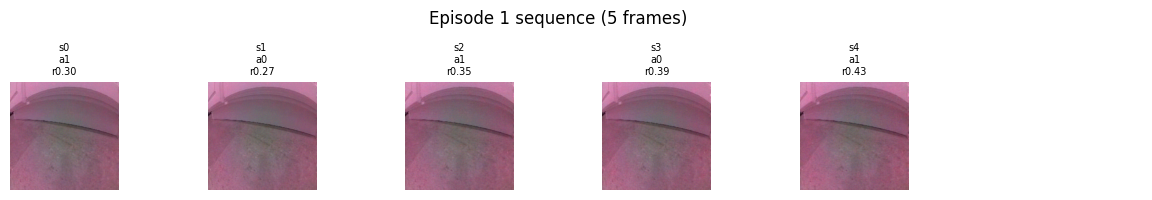

Episode 2 finished. Return = 1.537 | Duration = 4.82s


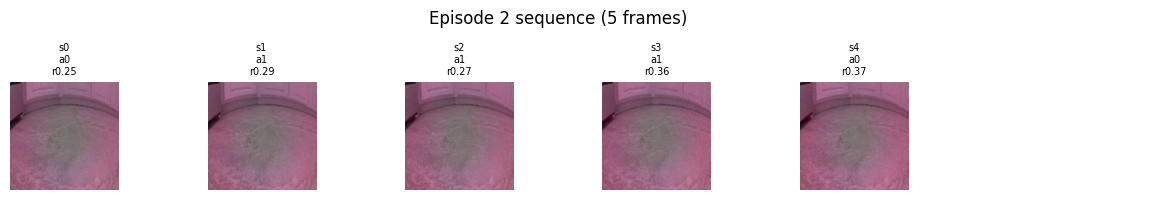

Episode 3 finished. Return = 2.665 | Duration = 4.80s


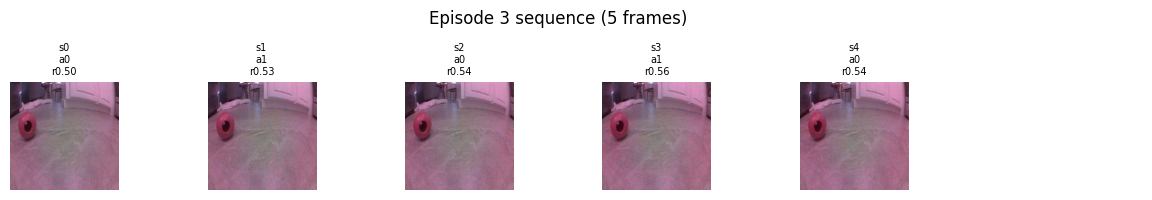

Episode 4 finished. Return = 1.760 | Duration = 4.83s


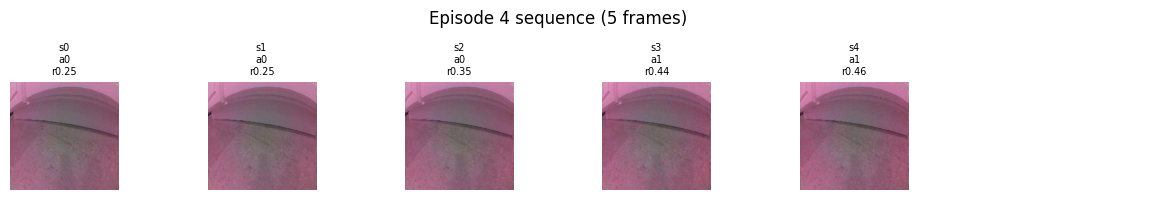

Episode 5 finished. Return = 2.323 | Duration = 4.81s


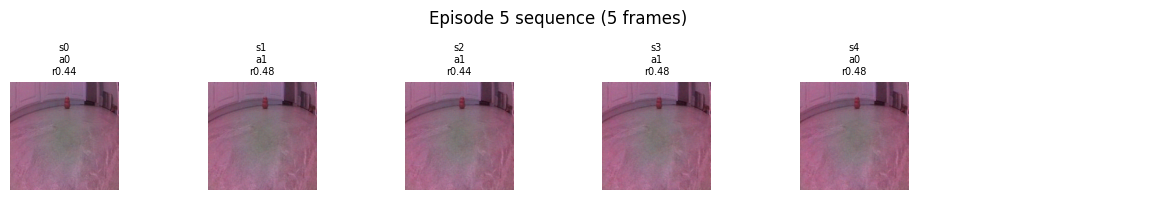

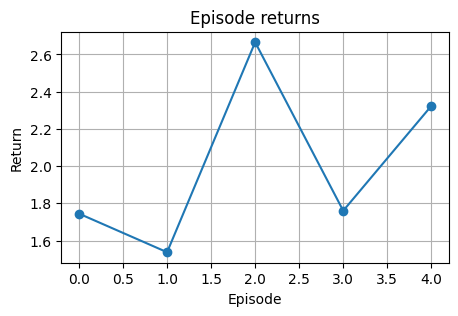

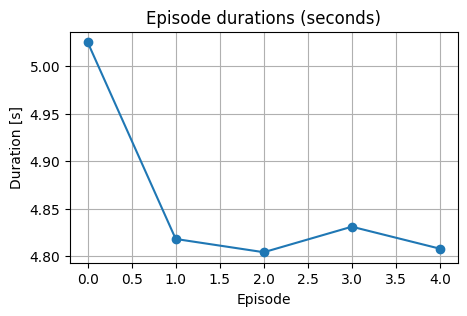

Average duration: 4.86 s ± 0.08


In [24]:
run_sim()